# Churn Drivers

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import graphviz
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind, pearsonr


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")
import prep
import acquire
import env

# Hypotheses

- The month in which a customer signs up will have an impact on the rate of churn.
- Features like internet service, type of phone service, online security and backup, senior citizens will affect the rate of churn.
- There will be a price point on some of the serves where churn will increse.
- The contract plan will affect the rate of churn.

# Acquisition


In [2]:
# Get churn data from customers table
df = acquire.get_telco_data()

 # data prep from prep.py file
df = prep.prep_telco(df)

In [3]:
def peekatdata(dataframe):
    head_df = df.head()
    tail_df = df.tail()
    head_tail = head_df.append(tail_df)
    print('Head and Tail\n\n', head_tail)
    print('--'*55)
    shape_tuple = df.shape
    print('Shape\n\n', shape_tuple)
    print('--'*20)
    describe_df = df.describe()
    print('Describe\n\n', describe_df)
    print('--'*20)
    print('Index\n\n', df.index)
    print('--'*20)
    print('Data Types\n\n', df.dtypes)
    print('--'*20)
    print('Null Value Count\n\n', df.isnull().sum())
    print('--'*55)
    print('Memory\n\n', df.memory_usage)

# Data Prep


In [4]:
def df_value_counts(df):
    for col in df.columns: 
        n = df[col].unique().shape[0] 
        col_bins = min(n,10) 
        if df[col].dtype in ['int64','float64'] and n > 10:
            print('%s:' % col)
            print(df[col].value_counts(bins=col_bins, sort=False)) 
        else: 
            print(df[col].value_counts()) 
        print('\n')


### Missing Values

We only found a few missing values in the total_charges column where tenure was 0. There was an empty string in that field so we replaced it with a 0 since a customer with 0 tenure would have 0 total charges due. Could not find any other nulls or NaNs. 



In [5]:
# Splitting the data into test and train sets

X = df.drop(['churn'], axis=1)
y = df[['churn']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123, stratify= y)


In [6]:
# Scaling the monthly and total charges to make data viz eaiser to work with

scaler = MinMaxScaler()
scaler.fit(X_train[['monthly_charges', 'total_charges']])

X_train[['monthly_charges', 'total_charges']] = scaler.transform(X_train[['monthly_charges', 'total_charges']])
X_test[['monthly_charges', 'total_charges']] = scaler.transform(X_test[['monthly_charges', 'total_charges']])

In [7]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Data Exploration


In [8]:
train['cumsum_churn'] = train.churn.cumsum()
train['rate_churn'] = train.cumsum_churn/train.churn.count()

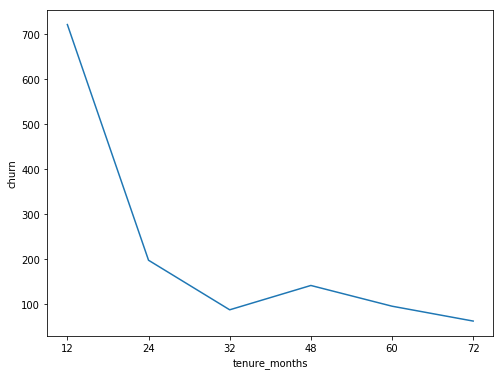

In [9]:
# Checking the churn rate for tenure groups 

bins = [12, 24, 32, 48, 60, 72]
train['tenure_months'] = pd.cut(train['tenure'], bins)

bins = [0, 12, 24, 32, 48, 60, 72]
labels = ['12', '24', '32', '48', '60', '72']
train['tenure_months'] = pd.cut(train['tenure'], bins=bins, labels=labels).where(train.churn == 1)

df1 = train.groupby('tenure_months')['churn'].count()
df1 = pd.DataFrame(df1)
df1 = df1.reset_index()
df1

plt.figure(figsize=(8,6))
ax = sns.lineplot(x="tenure_months", y="churn",data=df1)

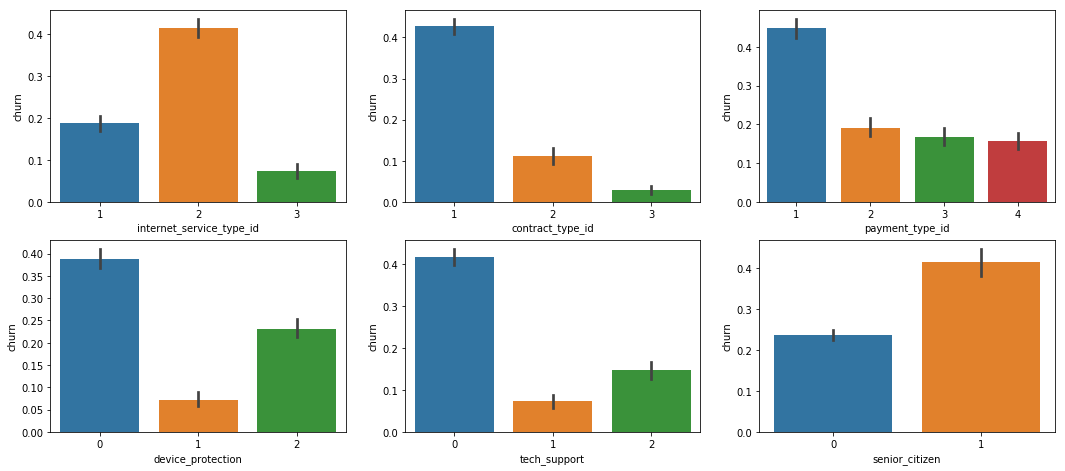

In [10]:
# The features that have the highest churn rate percent

plt.figure(figsize=(18,12))

plt.subplot(331)
sns.barplot(x=train.internet_service_type_id, y=train.churn)

plt.subplot(332)
sns.barplot(x=train.contract_type_id, y=train.churn)

plt.subplot(333)
sns.barplot(x=train.payment_type_id, y=train.churn)

plt.subplot(334)
sns.barplot(x=train.device_protection, y=train.churn)

plt.subplot(335)
sns.barplot(x=train.tech_support, y=train.churn)

plt.subplot(336)
sns.barplot(x=train.senior_citizen, y=train.churn)

In [11]:
# Churn rate of m2m vs 1 year contrat at the 1 year point

mtm = train[train.contract_type_id == 1]
mtm_after12 = mtm[mtm.tenure_year > 1]

mtmc = mtm_after12.churn.value_counts()
mtmc

print('Rate of churn for month-to-month: {:.2%}'.format(mtmc[1]/(mtmc[0]+mtmc[1])))

one_year = train[train.contract_type_id == 2]
one_year_after12 = one_year[one_year.tenure_year > 1]

one_yearc = one_year_after12.churn.value_counts()
one_yearc

print('Rate of churn for 1+ years: {:.2%}'.format(one_yearc[1]/(one_yearc[0]+one_yearc[1])))

Rate of churn for month-to-month: 33.53%
Rate of churn for 1+ years: 11.48%


Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

- statistic: 13.57
- pvalue: 3.18e-41
- From the TTest we can conclude there is a significantly difference between the two.

In [12]:
# Getting customers who have duplicate services.

dups = train[train.duplicated(['phone_id', 
                               'internet_service_type_id', 
                               'online_security_backup',
                               'device_protection', 
                               'tech_support', 
                               'contract_type_id'],
                                keep=False)]


In [13]:
# Finding the monthly_charges for the ones who have churned/not

churn = dups.loc[dups['churn'] == 1]['monthly_charges']
no_churn = dups.loc[dups['churn'] == 0]['monthly_charges']

In [14]:
# T test on the mean monthly_charges

ttest_ind(churn,no_churn)

Ttest_indResult(statistic=13.780089052045543, pvalue=2.039715011078695e-42)

How much of monthly_charges can be explained by internet_service_type? (hint: correlation test). State your hypotheses and your conclusion clearly.

- hypotheses: The internet_service_type will have an impact on the amount of monthly_charges. 
- conclusion: 31.9% of the varriance in monthly_charges can be explained by the internet_service_type.

In [15]:
pearsonr(train.monthly_charges, train.internet_service_type_id)

(-0.3236727414058814, 1.3145249985768094e-120)

##### Data Viz

In [16]:
# plt.figure(figsize=(20,20))
# sns.heatmap(train.corr(), annot=True, cmap='Greens')

In [17]:
# pd.crosstab(train.churn, train.contract_type_id, margins=True, normalize=True).style.background_gradient(cmap='YlOrRd')

In [18]:
# scatter = pd.scatter_matrix(
#      train.drop(columns=['cumsum_churn', 'rate_churn', 'tenure_months']), marker='o', s=40,
#      hist_kwds={'bins':15},  figsize=(25,25))

In [19]:
# sns.swarmplot(data=train, x='contract_type_id', y='monthly_charges', hue='churn')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [20]:
# sns.pairplot(data=train.drop(columns=['cumsum_churn', 'rate_churn', 'tenure_months']))

In [21]:
# sns.jointplot(x=train.monthly_charges, y=train.rate_churn, data=train)

In [22]:
# sns.relplot(data=train, x='tenure', y='total_charges', hue='churn')

In [23]:
# sns.distplot(train.tenure)

In [24]:
# sns.distplot(train.contract_type_id)

In [25]:
# sns.boxplot(data=train[['monthly_charges', 'total_charges']])

In [26]:
# with sns.axes_style('white'):
#     j = sns.jointplot("monthly_charges", "churn", data=train, kind='reg', height=5);
#     j.annotate(pearsonr)
# plt.show()

In [27]:
# g = sns.PairGrid(train.drop(columns=['cumsum_churn', 'rate_churn', 'tenure_months']))
# g.map_diag(plt.hist)
# g.map_offdiag(plt.scatter);

### Exploration Conclusions

- According to the above, the variables that do not have a strong enough correlation are gender, steaming services, house type,  and phone_id. We will drop these for our analysis. 
- The variables that do have a significant effect on churn rate are internet_service_type_id, contract_type_id, payment_type_id, device_protection, tech_support, and senior_citizen. We will focus on these features.  
---
- internet_service_type_id: Faster plans have higher cost and higher monthly bills drive churn.
- contract_type_id: month to month have the freedom to churn whenever so if they have higher monthly bills they are free to leave. 
- payment_type_id: 
- device_protection: Broken devices can lead them to leave 
- tech_support: No support can leadto frustration and cause them to churn
- senior_citizen: More likely to stop service for health/moving issues.

### Feature Engineer

- total_charges can be found from combing tenure and monthly_charges so we will drop that one to avoid repeating data


In [28]:
# Dropping explore columns that won't be used in modeling 

train = train.drop(columns= ['total_charges',
          'tenure_year',
          'household_type_id',
          'streaming_services',
          'phone_id',
          'online_security_backup',
          'gender',
          'cumsum_churn',
          'rate_churn',
          'tenure_months',
          'senior_citizen',
          'paperless_billing',
          'payment_type_id',
           'device_protection',
           'tech_support',
           'tenure'], axis=1)

test = test.drop(columns= ['total_charges',
          'tenure_year',
          'household_type_id',
          'streaming_services',
          'phone_id',
          'online_security_backup',
          'gender',
          'senior_citizen',
          'paperless_billing',
          'payment_type_id',
           'device_protection',
           'tech_support',
           'tenure'], axis=1)

# Modeling

### Logistic Regression

In [29]:
# All Features and no hyperparameters 

logis = LogisticRegression(random_state=123)

logis.fit(train.drop(columns=['customer_id'], axis=1), y_train)

y_pred_logis = logis.predict(train.drop(columns=['customer_id'], axis=1))

print('Confusion Matrix \n')
cm_fancy = pd.DataFrame(confusion_matrix(y_train, y_pred_logis),
            columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])
print(cm_fancy)

print('\nClassification Report - Train \n')
print(classification_report(y_train, y_pred_logis))

print('\nAccuracy of Decision Tree classifier on training set: {:.2f}'
     .format(logis.score(train.drop(columns=['customer_id'], axis=1), y_train)))

cm = confusion_matrix(y_train, y_pred_logis)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}\n'.format((fn/(fn + tp))*100))

y_pred_logis_test = logis.predict(test.drop(columns=['customer_id'], axis=1))

print('\nClassification Report - Test \n')
print(classification_report(y_test, y_pred_logis_test))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(logis.score(test.drop(columns=['customer_id'], axis=1), y_test)))

Confusion Matrix 

          Pred -  Pred +
Actual -    3622       0
Actual +       0    1308

Classification Report - Train 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      1308

   micro avg       1.00      1.00      1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930


Accuracy of Decision Tree classifier on training set: 1.00
False Positive Rate: 0.00
False Negatice Rate: 0.00


Classification Report - Test 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1552
           1       1.00      1.00      1.00       561

   micro avg       1.00      1.00      1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113

Accuracy of Decision Tree classifier on test set: 1.00


- Accuracy is ok but False Negative Rate  is bad as well as recall in test

In [30]:
# Selecting just internet_service_type_id, contract_type_id, monthly_charges and some hyperparameters.

logis = LogisticRegression(C=1, class_weight='balanced', random_state = 123, solver='saga')

logis.fit(train[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']], y_train)

y_pred_logis = logis.predict(train[['internet_service_type_id', 
                                'contract_type_id', 
                                'monthly_charges']])

print('Confusion Matrix \n')
cm_fancy = pd.DataFrame(confusion_matrix(y_train, y_pred_logis),
            columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])
print(cm_fancy)

print('\nClassification Report - Train \n')
print(classification_report(y_train, y_pred_logis))

print('\nAccuracy of Decision Tree classifier on training set: {:.2f}'
     .format(logis.score(train[['internet_service_type_id', 
                               'contract_type_id', 
                               'monthly_charges']], y_train)))

cm = confusion_matrix(y_train, y_pred_logis)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}\n'.format((fn/(fn + tp))*100))

y_pred_dtc_test = logis.predict(test[['internet_service_type_id', 
                                    'contract_type_id', 
                                    'monthly_charges']])

print('\nClassification Report - Test \n')
print(classification_report(y_test, y_pred_logis_test))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(logis.score(test[['internet_service_type_id', 
                             'contract_type_id', 
                             'monthly_charges']], y_test)))

Confusion Matrix 

          Pred -  Pred +
Actual -    2396    1226
Actual +     246    1062

Classification Report - Train 

              precision    recall  f1-score   support

           0       0.91      0.66      0.77      3622
           1       0.46      0.81      0.59      1308

   micro avg       0.70      0.70      0.70      4930
   macro avg       0.69      0.74      0.68      4930
weighted avg       0.79      0.70      0.72      4930


Accuracy of Decision Tree classifier on training set: 0.70
False Positive Rate: 33.85
False Negatice Rate: 18.81


Classification Report - Test 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1552
           1       1.00      1.00      1.00       561

   micro avg       1.00      1.00      1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113

Accuracy of Decision Tree classifier on test set: 0.71


- Accuracy is meh but False Positive Rate is not too good and recall in test is low

### Decision Tree

In [31]:
# All Features and no hyperparameters 

dtc = DecisionTreeClassifier(random_state=123)

dtc.fit(train.drop(columns=['customer_id'], axis=1), y_train)

y_pred_dtc = dtc.predict(train.drop(columns=['customer_id'], axis=1))

print('Confusion Matrix \n')
cm_fancy = pd.DataFrame(confusion_matrix(y_train, y_pred_dtc),
            columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])
print(cm_fancy)

print('\nClassification Report - Train \n')
print(classification_report(y_train, y_pred_dtc))

print('\nAccuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(train.drop(columns=['customer_id'], axis=1), y_train)))

cm = confusion_matrix(y_train, y_pred_dtc)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}\n'.format((fn/(fn + tp))*100))

y_pred_dtc_test = dtc.predict(test.drop(columns=['customer_id'], axis=1))

print('\nClassification Report - Test \n')
print(classification_report(y_test, y_pred_dtc_test))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(dtc.score(test.drop(columns=['customer_id'], axis=1), y_test)))

Confusion Matrix 

          Pred -  Pred +
Actual -    3622       0
Actual +       0    1308

Classification Report - Train 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      1308

   micro avg       1.00      1.00      1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930


Accuracy of Decision Tree classifier on training set: 1.00
False Positive Rate: 0.00
False Negatice Rate: 0.00


Classification Report - Test 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1552
           1       1.00      1.00      1.00       561

   micro avg       1.00      1.00      1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113

Accuracy of Decision Tree classifier on test set: 1.00


- Accuracy drops a lot, False Negative Rate is bad as well as recall in test

In [32]:
# Selecting just internet_service_type_id, contract_type_id, monthly_charges and some hyperparameters.

dtc = DecisionTreeClassifier(criterion='gini', class_weight= 'balanced', max_depth=3, random_state=123)
dtc.fit(train[['internet_service_type_id', 'contract_type_id',
       'monthly_charges']], y_train)

y_pred_dtc = dtc.predict(train[['internet_service_type_id', 'contract_type_id',
       'monthly_charges']])
y_prob_dtc = dtc.predict_proba(train[['internet_service_type_id', 'contract_type_id',
       'monthly_charges']])

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(train[['internet_service_type_id', 'contract_type_id',
       'monthly_charges']], y_train)))

cm = confusion_matrix(y_train, y_pred_dtc)
print(cm)
print(classification_report(y_train, y_pred_dtc))
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
accuracy = ((tn + tp)/total)*100
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}'.format((fn/(fn + tp))*100))

y_pred_dtc_test = dtc.predict(test[['internet_service_type_id', 'contract_type_id',
       'monthly_charges']])
y_prob_dtc_test = dtc.predict_proba(test[['internet_service_type_id', 'contract_type_id',
       'monthly_charges']])

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(dtc.score(test[['internet_service_type_id', 'contract_type_id',
       'monthly_charges']], y_test)))

print(classification_report(y_test, y_pred_dtc_test))


Accuracy of Decision Tree classifier on training set: 0.71
[[2420 1202]
 [ 226 1082]]
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      3622
           1       0.47      0.83      0.60      1308

   micro avg       0.71      0.71      0.71      4930
   macro avg       0.69      0.75      0.69      4930
weighted avg       0.80      0.71      0.73      4930

False Positive Rate: 33.19
False Negatice Rate: 17.28
Accuracy of Decision Tree classifier on test set: 0.71
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1552
           1       0.47      0.82      0.60       561

   micro avg       0.71      0.71      0.71      2113
   macro avg       0.69      0.75      0.69      2113
weighted avg       0.80      0.71      0.73      2113



- Accuracy is ok but False Positive Rate is ok and recall in test is great

In [33]:
train['prediction'] = y_pred_dtc

test['prediction'] = y_pred_dtc_test

csv_test_pred = test[['prediction', 'customer_id']]

csv_train_pred = train[['prediction', 'customer_id']]

csv_predict = pd.concat([csv_test_pred, csv_train_pred])


train['probability'] = y_prob_dtc[:, 1]
test['probability'] = y_prob_dtc_test[:, 1]

csv_test_prob1 = test[['probability', 'customer_id']]

csv_train_prob1 = train[['probability', 'customer_id']]

csv_prob1 = pd.concat([csv_test_prob1, csv_train_prob1])


csv_final = csv_predict.merge(csv_prob1, on='customer_id', how='inner')

csv_final.to_csv(r'/Users/stevengaris/Desktop/classification_project/csv_final.csv')

In [34]:
# A vizulation of the tree.

import graphviz
from sklearn.tree import export_graphviz

feature_names = ['internet_service_type_id',
            'contract_type_id',
               'monthly_charges']
class_names = ['not_churn', 'churn']

dot = export_graphviz(
    dtc,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names, # target value names
    special_characters=True,
    filled=True,             # fill nodes w/ informative colors
    impurity=False,          # show impurity at each node
    leaves_parallel=True,    # all leaves at the bottom
    proportion=True,         # show percentages instead of numbers at each leaf
    rotate=True,             # left to right instead of top-bottom
    rounded=True,            # rounded boxes and sans-serif font
)

graph = graphviz.Source(dot, filename='telco_decision_tree', format='png')
graph.view(cleanup=True)


'telco_decision_tree.png'

### Random Forest


In [35]:
# All Features and no hyperparameters 

rfc = RandomForestClassifier(random_state=123)

rfc.fit(train.drop(columns=['customer_id'], axis=1), y_train)

y_pred_rfc = rfc.predict(train.drop(columns=['customer_id'], axis=1))

print('Confusion Matrix \n')
cm_fancy = pd.DataFrame(confusion_matrix(y_train, y_pred_rfc),
            columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])
print(cm_fancy)

print('\nClassification Report - Train \n')
print(classification_report(y_train, y_pred_rfc))

print('\nAccuracy of Decision Tree classifier on training set: {:.2f}'
     .format(rfc.score(train.drop(columns=['customer_id'], axis=1), y_train)))

cm = confusion_matrix(y_train, y_pred_rfc)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}\n'.format((fn/(fn + tp))*100))

y_pred_rfc_test = rfc.predict(test.drop(columns=['customer_id'], axis=1))

print('\nClassification Report - Test \n')
print(classification_report(y_test, y_pred_rfc_test))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(rfc.score(test.drop(columns=['customer_id'], axis=1), y_test)))

Confusion Matrix 

          Pred -  Pred +
Actual -    3622       0
Actual +       0    1308

Classification Report - Train 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      1308

   micro avg       1.00      1.00      1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930


Accuracy of Decision Tree classifier on training set: 1.00
False Positive Rate: 0.00
False Negatice Rate: 0.00


Classification Report - Test 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1552
           1       1.00      1.00      1.00       561

   micro avg       1.00      1.00      1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113

Accuracy of Decision Tree classifier on test set: 1.00


- Accuracy drops a lot, False Rates are good, recall in test is low

In [36]:
# Selecting just internet_service_type_id, contract_type_id, monthly_charges and some hyperparameters.

rfc = RandomForestClassifier(bootstrap=True, 
                              class_weight=None, 
                              criterion='gini',
                              min_samples_leaf=3,
                              n_estimators=100,
                              max_depth=3, 
                              random_state=123)

rfc.fit(train[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']], y_train)

y_pred_rfc = rfc.predict(train[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']])

print('Confusion Matrix \n')
cm_fancy = pd.DataFrame(confusion_matrix(y_train, y_pred_rfc),
            columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])
print(cm_fancy)

print('\nClassification Report - Train \n')
print(classification_report(y_train, y_pred_rfc))

print('\nAccuracy of Decision Tree classifier on training set: {:.2f}'
     .format(rfc.score(train[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']], y_train)))

cm = confusion_matrix(y_train, y_pred_rfc)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}\n'.format((fn/(fn + tp))*100))

y_pred_rfc_test = rfc.predict(test[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']])

print('\nClassification Report - Test \n')
print(classification_report(y_test, y_pred_rfc_test))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(rfc.score(test[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']], y_test)))

Confusion Matrix 

          Pred -  Pred +
Actual -    3030     592
Actual +     556     752

Classification Report - Train 

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3622
           1       0.56      0.57      0.57      1308

   micro avg       0.77      0.77      0.77      4930
   macro avg       0.70      0.71      0.70      4930
weighted avg       0.77      0.77      0.77      4930


Accuracy of Decision Tree classifier on training set: 0.77
False Positive Rate: 16.34
False Negatice Rate: 42.51


Classification Report - Test 

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1552
           1       0.55      0.54      0.55       561

   micro avg       0.76      0.76      0.76      2113
   macro avg       0.69      0.69      0.69      2113
weighted avg       0.76      0.76      0.76      2113

Accuracy of Decision Tree classifier on test set: 0.76


- Accuracy is ok but False Negative Rate is a bit high and recall in test is bad

### KNN

In [38]:
# All Features and no hyperparameters 

knn = KNeighborsClassifier()

knn.fit(train.drop(columns=['customer_id'], axis=1), y_train)

y_pred_knn = knn.predict(train.drop(columns=['customer_id'], axis=1))

print('Confusion Matrix \n')
cm_fancy = pd.DataFrame(confusion_matrix(y_train, y_pred_knn),
            columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])
print(cm_fancy)

print('\nClassification Report - Train \n')
print(classification_report(y_train, y_pred_knn))

print('\nAccuracy of Decision Tree classifier on training set: {:.2f}'
     .format(knn.score(train.drop(columns=['customer_id'], axis=1), y_train)))

cm = confusion_matrix(y_train, y_pred_knn)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}\n'.format((fn/(fn + tp))*100))

y_pred_knn_test = knn.predict(test.drop(columns=['customer_id'], axis=1))

print('\nClassification Report - Test \n')
print(classification_report(y_test, y_pred_knn_test))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(knn.score(test.drop(columns=['customer_id'], axis=1), y_test)))

Confusion Matrix 

          Pred -  Pred +
Actual -    3622       0
Actual +       0    1308

Classification Report - Train 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      1308

   micro avg       1.00      1.00      1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930


Accuracy of Decision Tree classifier on training set: 1.00
False Positive Rate: 0.00
False Negatice Rate: 0.00


Classification Report - Test 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1552
           1       1.00      1.00      1.00       561

   micro avg       1.00      1.00      1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113

Accuracy of Decision Tree classifier on test set: 1.00


- Accuracy is ok but False Negative Rate is a bit high and recall in test is low

In [39]:
# Selecting just internet_service_type_id, contract_type_id, monthly_charges and some hyperparameters.

knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')

knn.fit(train[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']], y_train)

y_pred_knn = knn.predict(train[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']])

print('Confusion Matrix \n')
cm_fancy = pd.DataFrame(confusion_matrix(y_train, y_pred_knn),
            columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])
print(cm_fancy)

print('\nClassification Report - Train \n')
print(classification_report(y_train, y_pred_knn))

print('\nAccuracy of Decision Tree classifier on training set: {:.2f}'
     .format(knn.score(train[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']], y_train)))

cm = confusion_matrix(y_train, y_pred_knn)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
total = cm.sum()
print('False Positive Rate: {:.2f}'.format((fp/(fp + tn))*100))
print('False Negatice Rate: {:.2f}\n'.format((fn/(fn + tp))*100))

y_pred_knn_test = knn.predict(test[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']])

print('\nClassification Report - Test \n')
print(classification_report(y_test, y_pred_knn_test))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(knn.score(test[['internet_service_type_id',
               'contract_type_id',
               'monthly_charges']], y_test)))

Confusion Matrix 

          Pred -  Pred +
Actual -    3295     327
Actual +     500     808

Classification Report - Train 

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3622
           1       0.71      0.62      0.66      1308

   micro avg       0.83      0.83      0.83      4930
   macro avg       0.79      0.76      0.77      4930
weighted avg       0.83      0.83      0.83      4930


Accuracy of Decision Tree classifier on training set: 0.83
False Positive Rate: 9.03
False Negatice Rate: 38.23


Classification Report - Test 

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1552
           1       0.49      0.39      0.43       561

   micro avg       0.73      0.73      0.73      2113
   macro avg       0.64      0.62      0.63      2113
weighted avg       0.71      0.73      0.72      2113

Accuracy of Decision Tree classifier on test set: 0.73


- Accuracy is ok but False Negative Rate is a bit high and recall in test is low

([<matplotlib.axis.XTick at 0x1a1b61f4a8>,
 <a list of 5 Text xticklabel objects>)

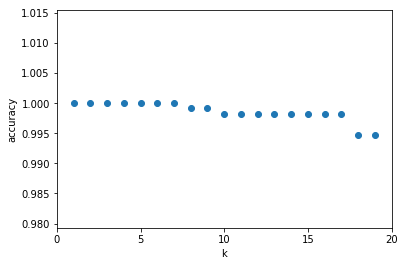

In [42]:
# Printing a graph of accuracy for each addition k neighbor

k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(train.drop(columns=['customer_id'], axis=1), y_train)
    scores.append(knn.score(train.drop(columns=['customer_id'], axis=1), y_train))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])


# Conclusion

- The decision tree with a few features and hyperparamaters selected returned the best test results.
- Train and Test accuracy is 71% so no overfitting. 
- A moderatly low False Positive Rate of 33.19%.
- A pretty low False Negatice Rate of 17.28%. 
- Recall on churn was 82% and non-churn was 67%.
- We can conclude that internet_service_type_id, contract_type_id, and monthly_charges have large impact on the rate of churn.

